In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import zipfile
import os
if not os.path.isdir('./Material'):
  zip_object = zipfile.ZipFile(file='/content/gdrive/MyDrive/Colab Notebooks/emotion_recognition/Material.zip', mode='r')
  zip_object.extractall('./')


In [6]:
if not os.path.isdir('./fer2013'):
  base_imgs = './Material/fer2013.zip'
  zip_object = zipfile.ZipFile(file=base_imgs, mode='r')
  zip_object.extractall('./')
  zip_object.close

#Acessando a Base de Dados:

In [7]:
data = pd.read_csv('./fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


Text(0.5, 1.0, 'Imagens x Emoções')

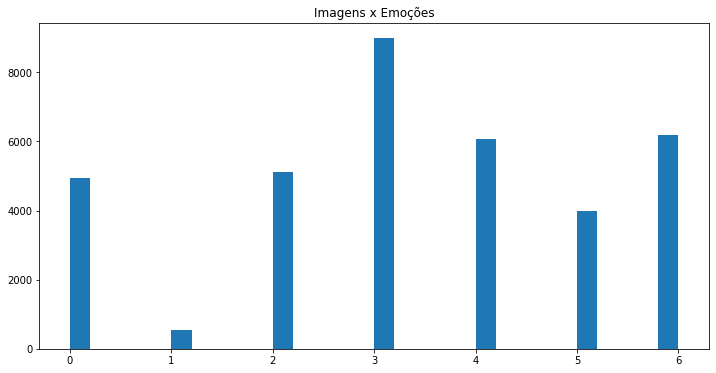

In [8]:
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins = 30)
plt.title('Imagens x Emoções')

#classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#Pré-Processamento:

In [9]:
pixels = data['pixels'].tolist()
len(pixels)

35887

In [10]:
h = w = 48
faces = [np.asarray([int(pixel) for pixel in pixel_sequence.split(' ')]).reshape(h,w) for pixel_sequence in pixels]

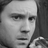

total number of images in this dataset: 35887


In [11]:
cv2_imshow(faces[0])
print(f'total number of images in this dataset: {len(faces)}')

In [12]:
faces = np.array(faces)
print(f'shape of faces: {faces.shape}')

shape of faces: (35887, 48, 48)


In [13]:
faces = np.expand_dims(faces, -1)
print(f'new shape of faces: {faces.shape}')

new shape of faces: (35887, 48, 48, 1)


In [14]:
def normalization(x):
  return x.astype('float32')/255.0


In [15]:
faces = normalization(faces)

In [16]:
faces[0]

array([[[0.27450982],
        [0.3137255 ],
        [0.32156864],
        ...,
        [0.20392157],
        [0.16862746],
        [0.16078432]],

       [[0.25490198],
        [0.23921569],
        [0.22745098],
        ...,
        [0.21960784],
        [0.20392157],
        [0.17254902]],

       [[0.19607843],
        [0.16862746],
        [0.21176471],
        ...,
        [0.19215687],
        [0.21960784],
        [0.18431373]],

       ...,

       [[0.35686275],
        [0.25490198],
        [0.16470589],
        ...,
        [0.28235295],
        [0.21960784],
        [0.16862746]],

       [[0.3019608 ],
        [0.32156864],
        [0.30980393],
        ...,
        [0.4117647 ],
        [0.27450982],
        [0.18039216]],

       [[0.3019608 ],
        [0.28235295],
        [0.32941177],
        ...,
        [0.41568628],
        [0.42745098],
        [0.32156864]]], dtype=float32)

In [17]:
#one-hot
emotions = pd.get_dummies(data['emotion']).values


In [18]:
emotions

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

#Imports of tensorflow/keras:

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, model_from_json

#Split the dataset


In [20]:
x_train, x_test, y_train,y_test= train_test_split(faces, emotions, test_size=.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.1, random_state=41)
np.save('model_x_test', x_test)
np.save('model_y_test', y_test)

In [21]:
print(f'train images number: {len(x_train)}')
print(f'test images number: {len(x_test)}')
print(f'validation images number: {len(x_val)}')



train images number: 29068
test images number: 3589
validation images number: 3230


#Model Architecture

In [22]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width = height = 48

model = Sequential()

model.add(Conv2D(num_features,(3,3), activation='relu', 
                 input_shape=(width, height, 1), data_format='channels_last', 
                 kernel_regularizer=l2(1e-2)))
model.add(Conv2D(num_features, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(.5))

model.add(Conv2D(2*num_features,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(.5))

model.add(Conv2D(4*num_features,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(.5))

model.add(Conv2D(8*num_features,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(8*num_features,(3,3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(.5))

model.add(Flatten())

model.add(Dense(8*num_features, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(4*num_features, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

#Compiling Model:

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

model_file = 'model_01_expressions.h5'
model_file_json = 'model_01_expressions.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=.9, patience=3, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss',patience=8, verbose=1)
checkpointer = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)

#Saving Model Architecture:

In [24]:
model_json = model.to_json()
with open(model_file_json, 'w') as json_file:
  json_file.write(model_json)

#Training Model:

In [25]:
history = model.fit(np.array(x_train), np.array(y_train), 
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data = (np.array(x_val), np.array(y_val)),
                    shuffle=True, callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/100
455/455 [==============================] - ETA: 0s - loss: 2.0243 - accuracy: 0.2088
Epoch 1: val_loss improved from inf to 1.83919, saving model to model_01_expressions.h5
455/455 [==============================] - 42s 58ms/step - loss: 2.0243 - accuracy: 0.2088 - val_loss: 1.8392 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 2/100
454/455 [============================>.] - ETA: 0s - loss: 1.8351 - accuracy: 0.2435
Epoch 2: val_loss improved from 1.83919 to 1.80789, saving model to model_01_expressions.h5
455/455 [==============================] - 26s 57ms/step - loss: 1.8351 - accuracy: 0.2435 - val_loss: 1.8079 - val_accuracy: 0.2594 - lr: 0.0010
Epoch 3/100
454/455 [============================>.] - ETA: 0s - loss: 1.8156 - accuracy: 0.2500
Epoch 3: val_loss improved from 1.80789 to 1.80357, saving model to model_01_expressions.h5
455/455 [==============================] - 26s 57ms/step - loss: 1.8155 - accuracy: 0.2500 - val_loss: 1.8036 - val_accuracy: 0.2594 - lr: 0.0010

#Building a graph:

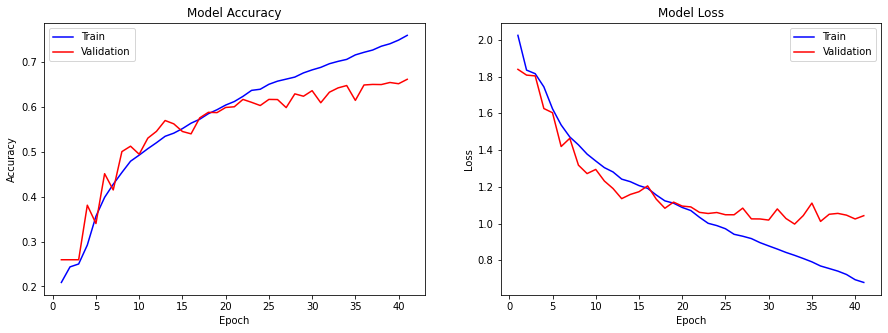

In [26]:
def plot_model_history(model_history):
  fig, axs = plt.subplots(1, 2, figsize=(15,5))
  axs[0].plot(range(1, len(model_history.history['accuracy'])+1), model_history.history['accuracy'], 'b', label='Train')
  axs[0].plot(range(1, len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'], 'r', label='Validation')
  axs[0].legend()
  axs[0].set_title('Model Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  
  axs[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'], 'b', label='Train')
  axs[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'], 'r', label='Validation')
  axs[1].legend()
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  fig.savefig(f'model01_history_graph.jpeg')
plot_model_history(history)

#Check Model Accuracy:

In [27]:
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)


57/57 [==============================] - 1s 17ms/step - loss: 1.0721 - accuracy: 0.6545


In [28]:
scores

[1.0720888376235962, 0.654499888420105]

In [29]:
print(f'Accuracy: {scores[1]}')
print(f'Loss: {scores[0]}')


Accuracy: 0.654499888420105
Loss: 1.0720888376235962


#Check Confusion Matrix:

In [30]:
true_y = []
pred_y = []
x = np.load('model_x_test.npy')
y = np.load('model_y_test.npy')

In [31]:
y[0]

array([0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [32]:
json_file = open(model_file_json, 'r')
loaded_model_json = json_file.read()
json_file.close()

In [33]:
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_file)

In [34]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

In [35]:
y_pred = loaded_model.predict(x)


113/113 [==============================] - 1s 7ms/step


In [36]:
y_pred

array([[1.0830716e-02, 1.3904784e-05, 1.5039426e-02, ..., 1.6974248e-02,
        1.7511500e-02, 1.1155133e-01],
       [7.9119293e-04, 1.2220931e-08, 5.8860815e-04, ..., 2.5207875e-03,
        7.6323090e-04, 9.1794275e-02],
       [3.3123550e-01, 4.4469792e-02, 1.5754372e-01, ..., 2.6037985e-01,
        1.1931459e-02, 1.8058333e-01],
       ...,
       [2.0405560e-05, 3.1340633e-10, 3.4713369e-02, ..., 6.7054330e-06,
        9.6500301e-01, 2.4645877e-04],
       [1.1869684e-02, 1.4364172e-06, 8.3878385e-03, ..., 4.5768600e-02,
        1.5041154e-04, 7.7318907e-01],
       [6.9114416e-05, 4.7341894e-11, 7.9216792e-05, ..., 5.8835046e-04,
        2.9466153e-05, 1.3530378e-02]], dtype=float32)

In [37]:
yp = np.argmax(y_pred, -1)
yt = np.argmax(y, -1)
print(f'shape of yp: {yp.shape}')
print(f'shape of yt: {yt.shape}')




shape of yp: (3589,)
shape of yt: (3589,)


In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

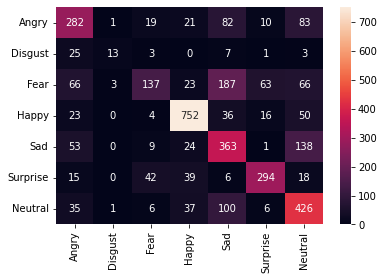

In [39]:
cm = confusion_matrix(yt, yp)
plot = sns.heatmap(cm, annot=True, 
                   xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], 
                   yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'],
                   fmt='g')
sns.set(rc={'figure.figsize':(10,8)})
fig = plot.get_figure()
fig.savefig('model01_confusion_matrix.jpeg')